Install Library

In [47]:
%pip install pandas
%pip install plotly
%pip install matplotlib
%pip install nbformat

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Import

In [48]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import re
from datetime import datetime, timedelta
import math
import os

Read file

In [49]:
with open('/home/drasogun/DraSoGun/Work/CANSAT_UDUCK/Hardware/Data/13_UDUCK.txt', 'r', encoding='utf-8', errors='replace') as f:
    text = f.read()

Clean Data

In [50]:
blocks = text.split('-------------')
print(blocks)
sec = -1
b = -1
data = []
vis = []
listxt = ('S','R','I',' ','.',',','-','0','1','2','3','4','5','6','7','8','9','\n',':')

for block in blocks:
    b += 1
    ch = 1
    for s in block:
        if s not in listxt:
            ch = 0
            break
    vis.append(ch)
for x in vis:
    print(x,end=" ")

['TIME=2025-05-30 04:36:15.036 SIZE=143 SF=9 CR=1 RSSIC=-112.40 CRC=26177 DATA=14.507813,100.933718\n4361200\n101\n12484\n3360\n75\n11\n\n35.74\n1006.86\n53.34\n66.03\n\n1.95,-8.62,3.77\n-4.34,-3.67,6.73\n-66.37,-11.72\n\n\nTIME=2025-05-30 04:36:39.445 SIZE=139 SF=9 CR=1 RSSIC=-115.40 CRC=26177 DATA=14.507817,100.933728\n4363700\n2\n8227\n3330\n78\n11\n\n35.80\n1007.07\n51.58\n66.06\n\n1.23,-9.58,1.71\n-0.69,0.72,-1.17\n-79.87,-7.21\n\n\nTIME=2025-05-30 04:36:41.141 SIZE=139 SF=9 CR=1 RSSIC=-111.40 CRC=26177 DATA=14.507817,100.933728\n4363700\n2\n8227\n3330\n78\n11\n\n35.81\n1006.98\n52.29\n66.06\n\n1.21,-9.54,1.68\n-0.80,1.02,-1.35\n-80.00,-7.14\nN\nJ\nTIME=2025-05-30 04:36:42.892 SIZE=139 SF=9 CR=1 RSSIC=-117.40 CRC=26177 DATA=14.507817,100.933729\n4364000\n1\n8227\n3350\n78\n11\n\n35.81\n1007.01\n52.07\n66.06\n\n1.23,-9.51,1.72\n-0.62,0.86,-1.43\n-79.73,-7.24\n\n\nTIME=2025-05-30 04:36:44.630 SIZE=139 SF=9 CR=1 RSSIC=-117.40 CRC=26177 DATA=14.507817,100.933729\n4364200\n2\n8227\n334

Add Data

In [51]:
import pandas as pd
import numpy as np
import re
import os

# ฟังก์ชันช่วย parse ค่าตัวเลข ถ้าแปลงไม่ได้ให้คืน np.nan
def try_parse_float(x):
    try:
        return float(x)
    except:
        return np.nan

def try_parse_int(x):
    try:
        return int(x)
    except:
        return np.nan

def try_parse_list_of_floats(x, length):
    """
    สูตรนี้จะแยกค่า x ตามเครื่องหมาย comma แล้วแปลงเป็น float
    ถ้าแถวไม่ครบ length ค่าใดแปลงไม่ได้ จะคืน list ของ np.nan ตามจำนวน length
    """
    parts = x.split(',')
    if len(parts) != length:
        return [np.nan] * length
    out = []
    for p in parts:
        try:
            out.append(float(p))
        except:
            out.append(np.nan)
    return out

# กำหนดพาธไปยังไฟล์ข้อมูลของคุณ (ปรับให้ตรงกับที่เก็บบนเครื่อง)
file_path = '/home/drasogun/DraSoGun/Work/CANSAT_UDUCK/Hardware/Data/13_UDUCK.txt'

if not os.path.exists(file_path):
    raise FileNotFoundError(f"ไม่พบไฟล์ที่พาธนี้: {file_path}")

# อ่านทุกบรรทัดที่ไม่ว่าง (strip) ลงใน list
with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
    lines = [line.strip() for line in f if line.strip()]

records = []
i = 0

while i < len(lines):
    # หาบรรทัดที่ขึ้นต้นด้วย 'TIME=' เป็นจุดเริ่มแต่ละบล็อค
    if lines[i].startswith('TIME='):
        header_line = lines[i]
        # ดึง TimeStamp เต็มๆ (yyyy-mm-dd hh:mm:ss.SSS)
        time_match = re.search(r'TIME=([\d\-: ]+\.\d+)', header_line)
        # ดึง latitude, longitude จาก "DATA=lat,lon"
        latlong_match = re.search(r'DATA=([\d\.\-]+),([\d\.\-]+)', header_line)

        if time_match:
            time_stamp = time_match.group(1)
        else:
            # ถ้า header ไม่มี timestamp ก็ข้ามบรรทัดนี้
            i += 1
            continue

        if latlong_match:
            lat = try_parse_float(latlong_match.group(1))
            lon = try_parse_float(latlong_match.group(2))
        else:
            # ถ้าไม่มีข้อมูล lat/lon เลย ให้ใส่ NaN
            lat = np.nan
            lon = np.nan

        # ตรวจสอบว่ามีอีก 13 บรรทัดถัดไปหรือไม่ (รวมเป็น 14 บรรทัดต่อบล็อค)
        if i + 13 >= len(lines):
            break

        # เตรียมค่า default สำหรับแต่ละฟิลด์
        raw_time = np.nan
        course = np.nan
        speed = np.nan
        alt_gps = np.nan
        hdop = np.nan
        sat = np.nan
        temp = np.nan
        pres = np.nan
        alt_bme = np.nan
        humidity = np.nan
        ax = ay = az = np.nan
        gx = gy = gz = np.nan
        roll = pitch = np.nan

        # 1) RawTime (บรรทัดถัดไป)
        raw1 = lines[i + 1]
        raw_time = try_parse_int(raw1)

        # 2) Course (float)
        course = try_parse_float(lines[i + 2])

        # 3) Speed (float)
        speed = try_parse_float(lines[i + 3])

        # 4) Altitude_GPS (float)
        alt_gps = try_parse_float(lines[i + 4])

        # 5) HDOP (float)
        hdop = try_parse_float(lines[i + 5])

        # 6) Satellite (int)
        sat = try_parse_int(lines[i + 6])

        # 7) Temp (float)
        temp = try_parse_float(lines[i + 7])

        # 8) Pressure (float)
        pres = try_parse_float(lines[i + 8])

        # 9) Altitude_BME280 (float)
        alt_bme = try_parse_float(lines[i + 9])

        # 10) Humidity (float)
        humidity = try_parse_float(lines[i + 10])

        # 11) Accel (x,y,z)
        accel_vals = try_parse_list_of_floats(lines[i + 11], 3)
        ax, ay, az = accel_vals

        # 12) Gyro (x,y,z)
        gyro_vals = try_parse_list_of_floats(lines[i + 12], 3)
        gx, gy, gz = gyro_vals

        # 13) Roll & Pitch
        roll_pitch_vals = try_parse_list_of_floats(lines[i + 13], 2)
        roll, pitch = roll_pitch_vals

        # สร้าง dict เก็บข้อมูลบล็อคนี้ (แต่ละแถวถ้าแปลงไม่ได้จะเป็น NaN)
        record = {
            'TimeStamp': time_stamp,
            'RawTime': raw_time,
            'Latitude': lat,
            'Longitude': lon,
            'Course': course,
            'Speed': speed,
            'Altitude_GPS': alt_gps,
            'HDOP': hdop,
            'Satellite': sat,
            'Temp': temp,
            'Pressure': pres,
            'Altitude_BME280': alt_bme,
            'Humidity': humidity,
            'Acc_x': ax,
            'Acc_y': ay,
            'Acc_z': az,
            'Gyro_x': gx,
            'Gyro_y': gy,
            'Gyro_z': gz,
            'Roll': roll,
            'Pitch': pitch
        }
        records.append(record)

        # ขยับไปบล็อคถัดไป (ข้าม 14 บรรทัด)
        i += 14
    else:
        # ถ้าไม่ใช่แถว header ก็ข้ามบรรทัดต่อไป
        i += 1

# สร้าง DataFrame จากรายการ records
df = pd.DataFrame(records)

# แปลงคอลัมน์ TimeStamp ให้เป็น datetime (ถ้า parse ไม่ได้จะ error จึง assume header ถูกต้องเสมอ)
df['TimeStamp'] = pd.to_datetime(df['TimeStamp'], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')

# สร้างคอลัมน์ TimeFloor = timestamp ปัดลงเป็นวินาที (floor)
df['TimeFloor'] = df['TimeStamp'].dt.floor('S')

# กำหนด t0 เป็นเวลาต่ำสุด (ในระดับวินาที) เพื่อให้ Second เริ่มจาก 0
t0 = df['TimeFloor'].min()
df['Second'] = (df['TimeFloor'] - t0).dt.total_seconds().astype('Int64')  # ใช้ Int64 เพื่อให้ NaN เก็บได้

# สร้าง DataFrame ของ full seconds ตั้งแต่ 0 ถึง max_second
max_second = int(df['Second'].max())
full_seconds = pd.DataFrame({'Second': range(0, max_second + 1)})

# ทำ merge แบบ left join ระหว่าง full_seconds กับ df
merged = pd.merge(full_seconds, df, on='Second', how='left', suffixes=('', '_orig'))

# เติมคอลัมน์ TimeStamp หลัง merge ให้เป็น TimeFloor
merged['TimeStamp'] = merged['TimeFloor']



/tmp/ipykernel_1051799/3255846952.py:173: FutureWarning:

'S' is deprecated and will be removed in a future version, please use 's' instead.



Data Fram

In [52]:
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [53]:
# df = merged
merged

,Second,TimeStamp,RawTime,Latitude,Longitude,Course,Speed,Altitude_GPS,HDOP,Satellite,Temp,Pressure,Altitude_BME280,Humidity,Acc_x,Acc_y,Acc_z,Gyro_x,Gyro_y,Gyro_z,Roll,Pitch,TimeFloor
0,0,2025-05-30 04:36:15,4361200.0,14.507813,100.933718,101.0,12484.0,3360.0,75.0,11.0,35.74,1006.86,53.34,66.03,1.95,-8.62,3.77,-4.34,-3.67,6.73,-66.37,-11.72,2025-05-30 04:36:15
1,1,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
2,2,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
3,3,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
4,4,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
641,639,2025-05-30 04:46:54,4464800.0,14.509564,100.933183,1.0,110.0,2680.0,67.0,12.0,179.50,-208.79,NaN,100.00,0.32,-9.63,-0.21,-1.44,0.73,-2.49,-91.23,-1.91,2025-05-30 04:46:54
642,640,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
643,641,2025-05-30 04:46:56,4465300.0,14.509564,100.933183,1.0,110.0,2670.0,67.0,12.0,179.50,-208.79,NaN,100.00,0.43,-9.68,-0.14,-0.63,0.94,-1.20,-90.84,-2.56,2025-05-30 04:46:56
644,642,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


In [54]:
df = merged

Plot graph

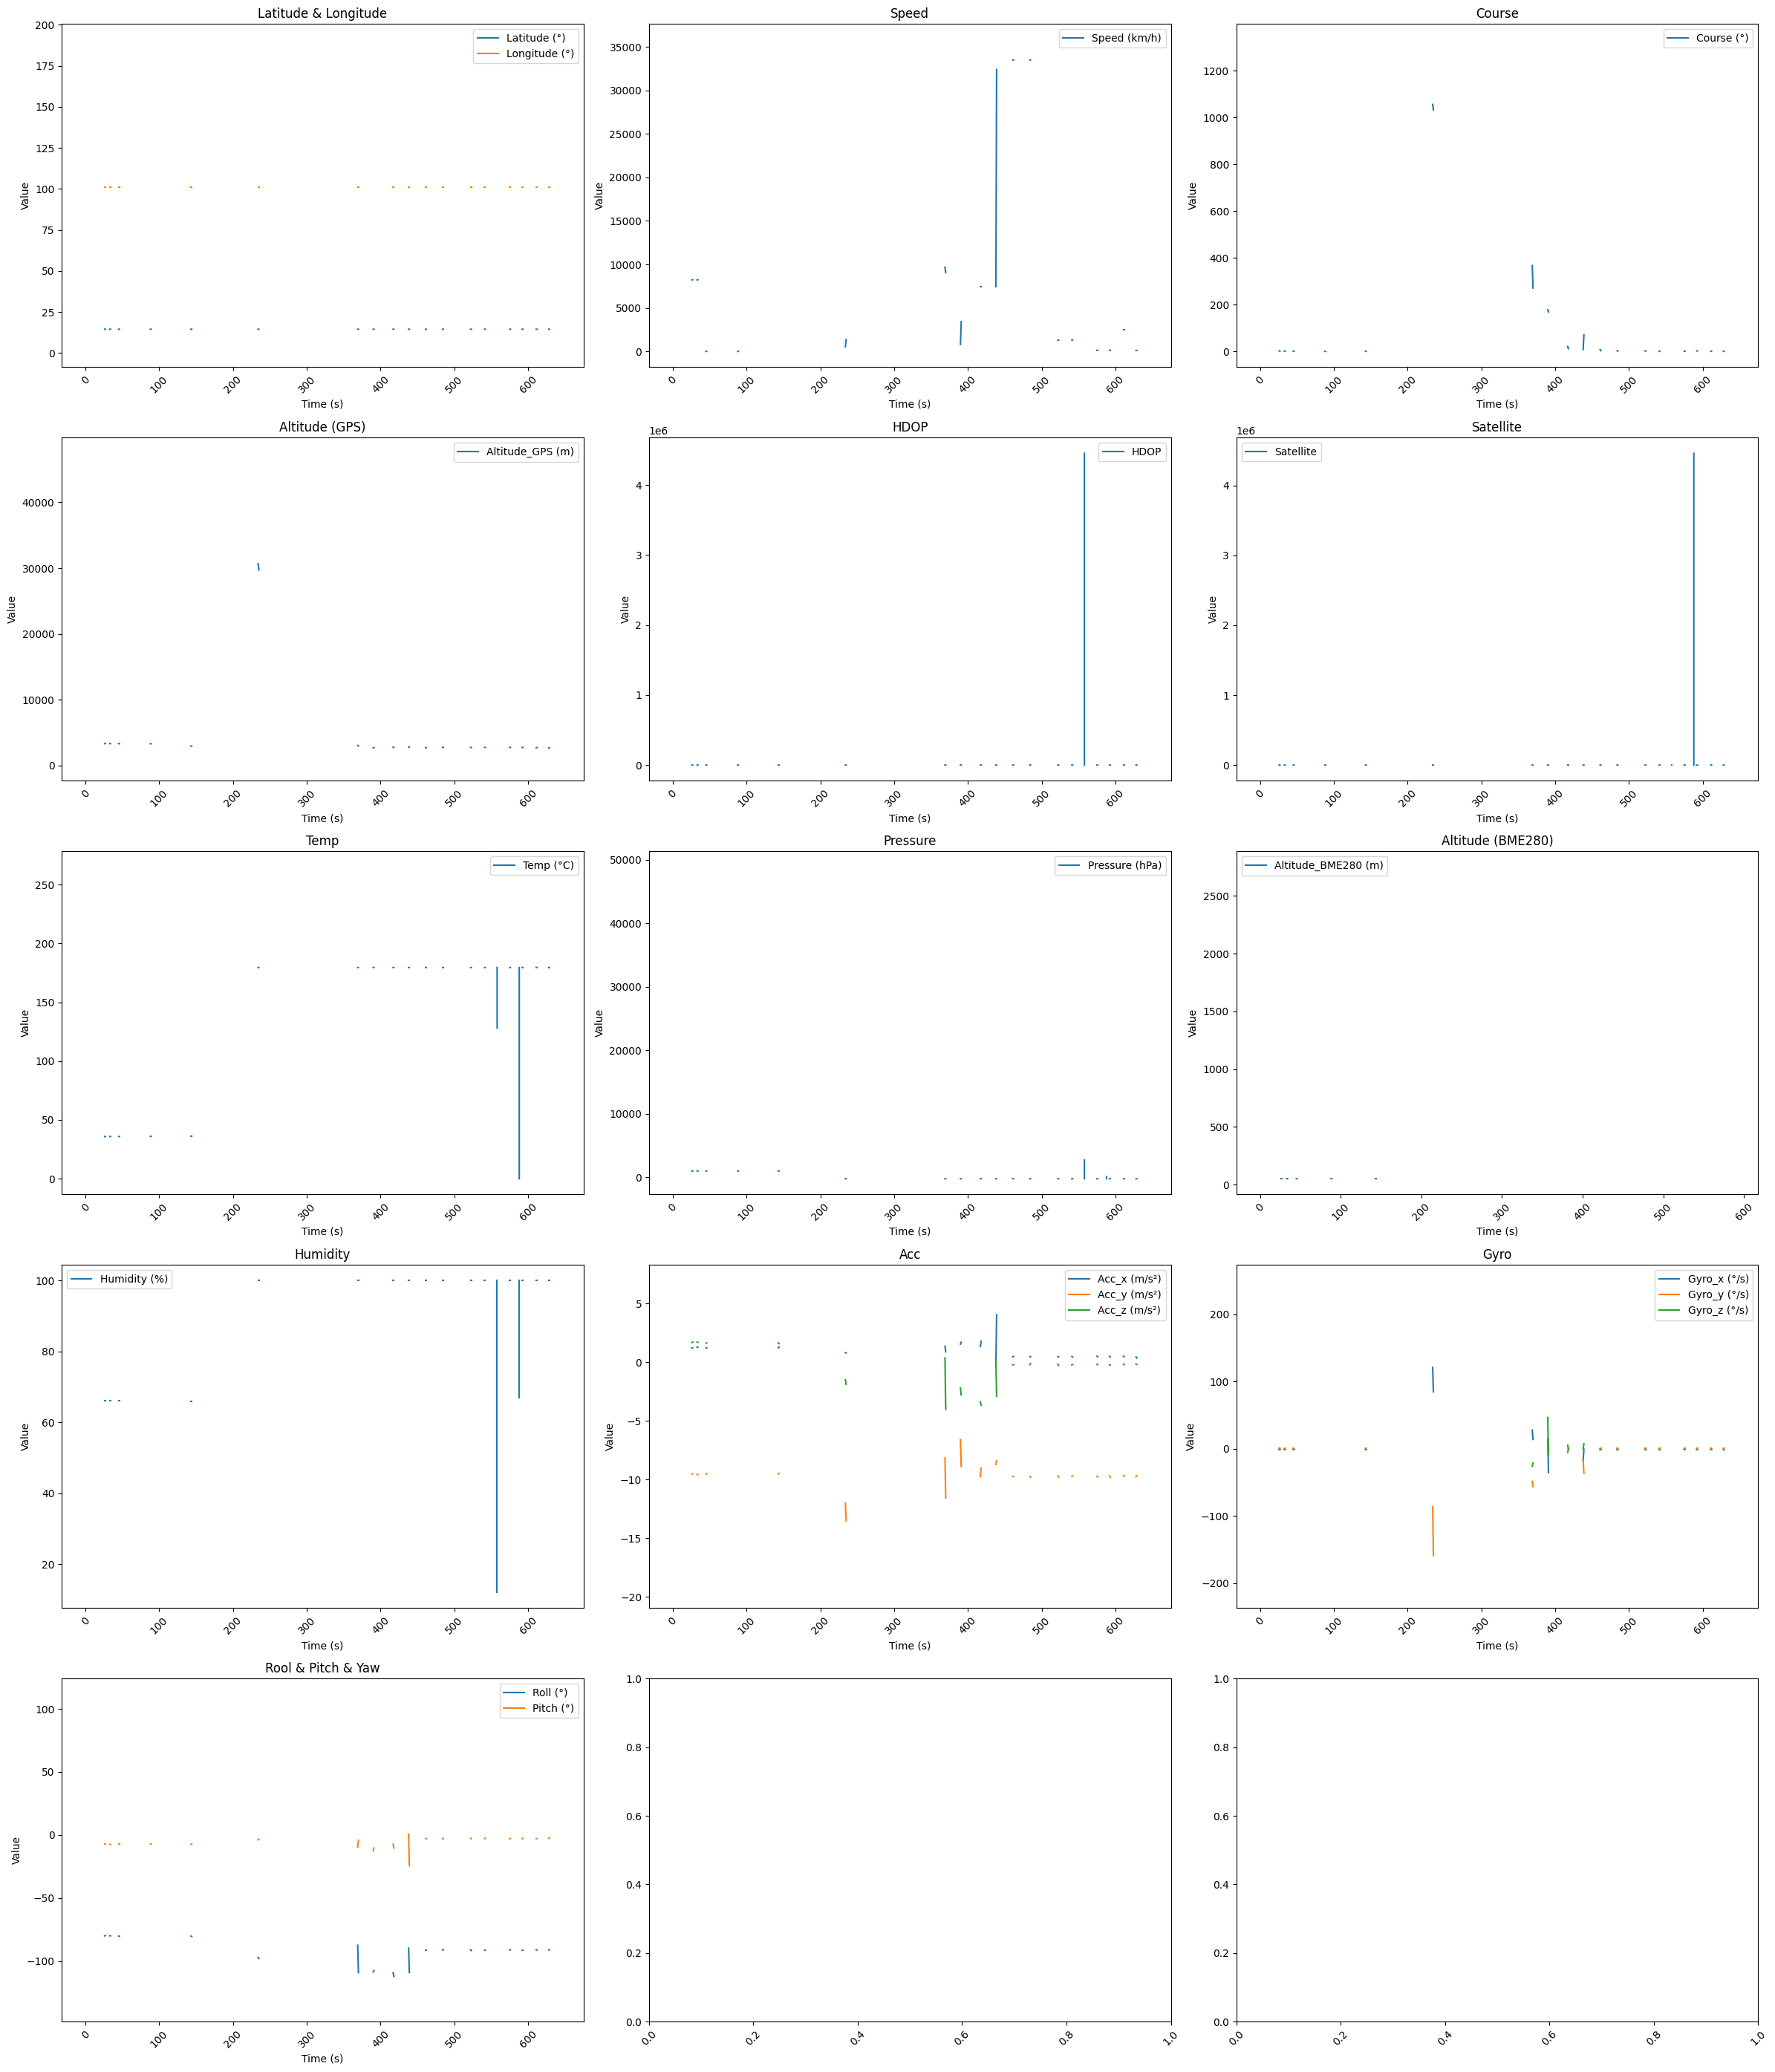

In [55]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 3,figsize=(24, 28))
ax1, ax2, ax3, ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12,ax13,ax14,ax15 = axes.flatten()

# Latitude & Longitude
ax1.plot(df['Second'], df['Latitude'], label='Latitude (°)')
ax1.plot(df['Second'], df['Longitude'], label='Longitude (°)')
ax1.set_title('Latitude & Longitude')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Value')
ax1.legend()

# Speed
ax2.plot(df['Second'], df['Speed'], label='Speed (km/h)')
ax2.set_title('Speed')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Value')
ax2.legend()

# Course
ax3.plot(df['Second'], df['Course'], label='Course (°)')
ax3.set_title('Course')
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Value')
ax3.legend()

# Altitude_GPS
ax4.plot(df['Second'], df['Altitude_GPS'], label='Altitude_GPS (m)')
ax4.set_title('Altitude (GPS)')
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('Value')
ax4.legend()

# HDOP	
ax5.plot(df['Second'], df['HDOP'], label='HDOP')
ax5.set_title('HDOP')
ax5.set_xlabel('Time (s)')
ax5.set_ylabel('Value')
ax5.legend()

# Satellite
ax6.plot(df['Second'], df['Satellite'], label='Satellite')
ax6.set_title('Satellite')
ax6.set_xlabel('Time (s)')
ax6.set_ylabel('Value')
ax6.legend()

# Temp
ax7.plot(df['Second'], df['Temp'], label='Temp (°C)')
ax7.set_title('Temp')
ax7.set_xlabel('Time (s)')
ax7.set_ylabel('Value')
ax7.legend()

# Pressure
ax8.plot(df['Second'], df['Pressure'], label='Pressure (hPa)')
ax8.set_title('Pressure')
ax8.set_xlabel('Time (s)')
ax8.set_ylabel('Value')
ax8.legend()

# Altitude_BME280
ax9.plot(df['Second'], df['Altitude_BME280'], label='Altitude_BME280 (m)')
ax9.set_title('Altitude (BME280)')
ax9.set_xlabel('Time (s)')
ax9.set_ylabel('Value')
ax9.legend()

# Humidity
ax10.plot(df['Second'], df['Humidity'], label='Humidity (%)')
ax10.set_title('Humidity')
ax10.set_xlabel('Time (s)')
ax10.set_ylabel('Value')
ax10.legend()

# Acc
ax11.plot(df['Second'], df['Acc_x'], label='Acc_x (m/s²)')
ax11.plot(df['Second'], df['Acc_y'], label='Acc_y (m/s²)')
ax11.plot(df['Second'], df['Acc_z'], label='Acc_z (m/s²)')
ax11.set_title('Acc')
ax11.set_xlabel('Time (s)')
ax11.set_ylabel('Value')
ax11.legend()

# Gyro
ax12.plot(df['Second'], df['Gyro_x'], label='Gyro_x (°/s)')
ax12.plot(df['Second'], df['Gyro_y'], label='Gyro_y (°/s)')
ax12.plot(df['Second'], df['Gyro_z'], label='Gyro_z (°/s)')
ax12.set_title('Gyro')
ax12.set_xlabel('Time (s)')
ax12.set_ylabel('Value')
ax12.legend()

# Roll Pitch Yaw
ax13.plot(df['Second'], df['Roll'], label='Roll (°)')
ax13.plot(df['Second'], df['Pitch'], label='Pitch (°)')
ax13.set_title('Rool & Pitch & Yaw')
ax13.set_xlabel('Time (s)')
ax13.set_ylabel('Value')
ax13.legend()

# RSSI
# ax14.plot(df['Second'], df['RSSI'], label='RSSI')
# ax14.set_title('RSSI')
# ax14.set_xlabel('Time (s)')
# ax14.set_ylabel('Value')
# ax14.legend()

# หมุน tick labels ทุกกราฟ
for ax in axes.flatten():
    for label in ax.get_xticklabels():
        label.set_rotation(45)

fig.tight_layout()
plt.show()


Map

In [56]:
fig = px.scatter_mapbox(
    df,
    lat="Latitude",
    lon="Longitude",
    hover_name="Second",
    zoom=12,
    height=600,
    mapbox_style="open-street-map"
)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()


/tmp/ipykernel_1051799/3941647903.py:1: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/

